Discard: Test code for inference with basis functions

In [3]:
import torch
import swyft
import pylab as plt
import numpy as np
import scipy
import swyft

## Helper functions

### Statistics

In [31]:
def logdiffcdf(dist, a, b):
    if dist.cdf(b) < 0.5:
        return np.log(dist.cdf(b) - dist.cdf(a))
    else:
        return np.log(dist.sf(a) - dist.sf(b))
    
def logdiffcdf(dist, a, b):
    return np.where(dist.cdf(b) < 0.5,
        np.log(dist.cdf(b) - dist.cdf(a)),
        np.log(dist.sf(a) - dist.sf(b))
            )

def trunc_sample(dist, r, size = None, return_logdiffcdf = True):
    r = np.array(r)
    c = dist.cdf(r)
    s = scipy.stats.uniform(loc = c[...,0], scale = c[...,1] - c[...,0]).rvs(size=size)
    z = np.array(dist.ppf(s))
    if not return_logdiffcdf:
        return z
    else:
        l = logdiffcdf(dist, r[...,0], r[...,1])
        return z, l
    
def get_trunc_draws(Ntrials, truncs):
    draws = [trunc_prior(truncs) for _ in range(Ntrials)]
    weights = np.array([v['weight'] for v in draws])
    mask = weights/weights.max() > np.random.rand(len(weights))
    return [draws[i] for i in np.arange(Ntrials)[mask]]

### SWYFT Modeling

In [32]:
from swyft.utils.array import array_to_tensor
class SimpleDataset(torch.utils.data.Dataset):                                                                                                                                                 
    """Dataset which merely keeps track of observation and parameter data in one place"""                                                                                                      
                                                                                                                                                                                               
    def __init__(self, observations, us, vs) -> None:                                                                                                                   
        """                                                                                                                                                                                    
        Args:                                                                                                                                                                                  
            observations: dictionary of batched obserations                                                                                                                                    
            us: array or tensor of unit cube parameters                                                                                                                                        
            vs: array or tensor of natural parameters                                                                                                                                          
        """                                                                                                                                                                                    
        super().__init__()                                                                                                                                                                     
        b = us.shape[0]                                                                                                                                                                        
        assert (                                                                                                                                                                               
            vs.shape[0] == b                                                                                                                                                                   
        ), "the us and vs arrays do not have the same batch dimension"                                                                                                                         
        assert all(                                                                                                                                                                            
            [b == x.shape[0] for x in observations.values()]                                                                                                                                   
        ), "the observation values do not have the same batch dimension as us and vs"                                                                                                          
        self.observations = observations                                                                                                                                                       
        self.us = us                                                                                                                                                                           
        self.vs = vs                                                                                                                                                                           
        self._len = b           
        
    def pnames(self):
        return None
    
    def prior(self):
        return None
    
    def bound(self):
        return None
    
    @property
    def requires_sim(self):
        return False
                                                                                                                                                                                               
    def __getitem__(self, idx):
        return (                                                                                                                                                                               
            {                                                                                                                                                                                  
                key: array_to_tensor(val[idx, ...])                                                                                                                                            
                for key, val in self.observations.items()                                                                                                                                      
            },                                                                                                                                                                                 
            array_to_tensor(self.us[idx, ...]),                                                                                                                                                
            array_to_tensor(self.vs[idx, ...]),                                                                                                                                                
        )                                                                                                                                                                                      
                                                                                                                                                                                               
    def __len__(self) -> int:                                                                                                                                                                  
        return self._len

In [33]:
class DistributionRatio(torch.nn.Module):
    def __init__(self, dist, *shape):
        super().__init__()
        self.dist = dist
        self.log_prefactor = torch.nn.Parameter(torch.zeros(*shape))
        self.log_scale = torch.nn.Parameter(torch.zeros(*shape))
        
    def bounds(self, m, epsilon):
        scale = torch.exp(self.log_scale)
        r0 = torch.zeros_like(m) + epsilon
        r1 = torch.ones_like(m) - epsilon
        b0 = self.dist(m, scale).icdf(r0)
        b1 = self.dist(m, scale).icdf(r1)
        return torch.vstack([b0, b1])
    
    def forward(self, z, m, return_bounds = None):
        if return_bounds:
            return self.bounds(m, return_bounds)
        scale = torch.exp(self.log_scale)
        log_ratio = self.dist(m, scale).log_prob(z) + self.log_prefactor
        return log_ratio

In [34]:
class View:
    def __init__(self, **shapes):
        self._shapes = shapes
        self._i0 = {}
        self._i1 = {}
        
        N = 0
        for key, value in shapes.items():
            n = np.prod(value)
            self._i0[key] = N
            self._i1[key] = N + n
            N += n
        
        self._N = N
        
    def __len__(self):
        return self._N

class Viewer:
    def __init__(self, view, u):
        self._view = view
        self._u = u
        
    def __getattr__(self, key):
        ucut = self._u[..., self._view._i0[key]:self._view._i1[key]]
        if type(ucut) == np.ndarray:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])  # TODO Redunadnt
        else:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])
    
    def __setattr__(self, key, value):
        if key[:1] == '_':
            object.__setattr__(self, key, value)
        else:
            if type(value) == np.ndarray:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))  # TODO Redundant
            else:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))
            self._u[..., self._view._i0[key]:self._view._i1[key]] = value_shaped
    
    def __len__(self):
        return self._view._N
    
    def __call__(self):
        return self._u

## Model definition

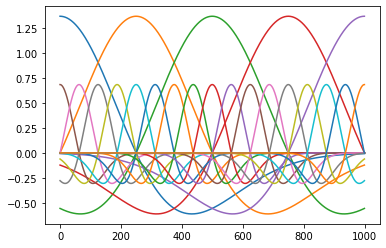

In [111]:
# Define basis functions (Using Ricker wavelet / Mexican hat wavelet)

N = 1000
X = np.linspace(0, 10, N)
t_func = lambda z, sigma: 2/np.sqrt(3*sigma)/np.pi**0.25*(1-((X-z)/sigma)**2)*np.exp(-(X-z)**2/2/sigma**2)*sigma

conf = []
for k in [2, 8]:
    conf += [[x, 5/k] for x in np.linspace(0, 10, 2*k+1)]
#conf += [[x, 1.25] for x in np.linspace(0, 10, 9)]
#conf += [[x, 1.] for x in np.linspace(0, 10, 11)]
#conf += [[x, 0.5] for x in np.linspace(0, 10, 21)]
#conf += [[x, 0.2] for x in np.linspace(0, 10, 33)]
#conf += [[x, 0.1] for x in np.linspace(0, 10, 65)]
M = len(conf)
T = np.zeros((M, N))
for i in range(M):
    T[i,:] = t_func(conf[i][0], conf[i][1])
T = T.T
plt.plot(T);

51.07306406704022

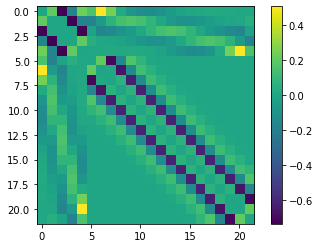

In [112]:
C = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        C[i, j] = (T[:,i] * T[:,j]).sum()
        C[i, j] /= (T[:,i]**2).sum()**0.5
        C[i, j] /= (T[:,j]**2).sum()**0.5
        C[i, i] = 0
plt.imshow(C, interpolation='nearest')
plt.colorbar()
abs(C).sum()

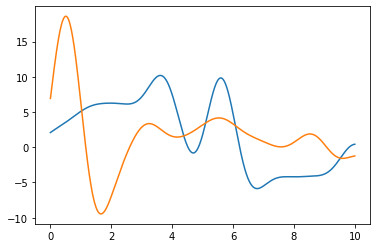

In [149]:
# Random examples

for _ in range(2):
    #v = np.random.randn(M)
    #v = scipy.stats.expon(0, .1).rvs((M,))**10
    v = scipy.stats.halfcauchy(0, 1).rvs((M,))
    #plt.plot(X, np.exp(T.dot(v)*0.5))
    plt.plot(X, T.dot(v))

In [79]:
SIGMA = 0.01  # Measurement uncertainty

In [80]:
def prior():
    z = scipy.stats.expon(0.1).rvs((M,))
    return dict(z = z)

def trunc_prior(truncs):
    z, log_prob_z = trunc_sample(scipy.stats.expon(0.1), truncs['z'])
    return dict(z = z, weight = 1.)

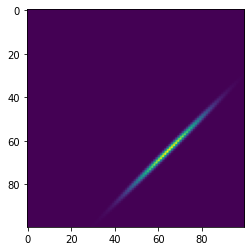

In [196]:
a = b = np.linspace(0, 1, 100)
L = lambda a, b: -(a+b-1.3)**2/2/0.01**2 - (a-b)**2/2*20
g = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        g[i, j] = L(a[i], b[j])
        g[i, j] += -a[i]**2
        g[i, j] += -b[j]**2
        
g = np.exp(g)
plt.imshow(g)

In [81]:
view = View(z = (M,))

def model(v):
    vv = Viewer(view, v)
    x = T.dot(vv.z)
    #x = np.exp(x*0.5)
    return dict(x=x)
    
# Noise model
def noise(sim, v):
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['x'] + noise)

def transform(u):
    return u
    
NPAR = M

## Network

In [95]:
class RatioSampler(swyft.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rz = DistributionRatio(torch.distributions.LogNormal, (NPAR,))
        self.get_mz1 = torch.nn.Sequential(
            torch.nn.AvgPool1d(50),
            torch.nn.Conv1d(1, 16, 10),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, 1),
            torch.nn.LazyLinear(3)
        )
        self.get_mz2 = torch.nn.Sequential(
            torch.nn.AvgPool1d(25),
            torch.nn.Conv1d(1, 16, 10),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, 1),
            torch.nn.LazyLinear(5)
        )
        self.get_mz3 = torch.nn.Sequential(
            torch.nn.AvgPool1d(10),
            torch.nn.Conv1d(1, 16, 10),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, 1),
            torch.nn.LazyLinear(9)
        )
        self.get_mz4 = torch.nn.Sequential(
            torch.nn.AvgPool1d(5),
            torch.nn.Conv1d(1, 16, 10),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, 1),
            torch.nn.LazyLinear(17)
        )
        self.get_mz5 = torch.nn.Sequential(
            torch.nn.AvgPool1d(2),
            torch.nn.Conv1d(1, 16, 10),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, 1),
            torch.nn.LazyLinear(33)
        )
        self.get_mz6 = torch.nn.Sequential(
            torch.nn.AvgPool1d(1),
            torch.nn.Conv1d(1, 16, 10),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, 1),
            torch.nn.LazyLinear(65)
        )
        self.get_mz = torch.nn.Sequential(
            torch.nn.Linear(1000, 4000),
            torch.nn.ReLU(),
            torch.nn.Linear(4000, 4000),
            torch.nn.ReLU(),
            torch.nn.Linear(4000, NPAR)
        )
        self.bn = torch.nn.BatchNorm1d(N, momentum = 0.01, affine = False, eps = 1.)
    
    def embedding(self, x):
        return x

    def forward(self, x, u, return_bounds = None):
        f = self.embedding(x)
        
        uv = Viewer(view, u)
        
        mz1 = self.get_mz1(f.unsqueeze(1)).squeeze(1)
        mz2 = self.get_mz2(f.unsqueeze(1)).squeeze(1)
        mz3 = self.get_mz3(f.unsqueeze(1)).squeeze(1)
        mz4 = self.get_mz4(f.unsqueeze(1)).squeeze(1)
        mz5 = self.get_mz5(f.unsqueeze(1)).squeeze(1)
        mz6 = self.get_mz6(f.unsqueeze(1)).squeeze(1)
        #mz = torch.hstack([mz1, mz2, mz3, mz4, mz5, mz6])
        mz = torch.hstack([mz2, mz4])
        #mz = torch.hstack([mz1, mz2])
        #print(mz.shape)
        
        #mz = self.get_mz(f)
        #print(mz.shape)
        rz = self.rz(uv.z, mz, return_bounds = return_bounds)
        
        #r = torch.hstack([rz, rb])
        r = rz
        return r

## Analysis

In [96]:
NTRAIN = 10000

def get_prior_samples():
    s = np.zeros((NTRAIN, NPAR))
    vu = Viewer(view, s)
    for i in range(len(s)):
        p = prior()
        vu.z[i] = p['z']
    return s

s = get_prior_samples()

In [97]:
# Set dataset

observations = {"x": np.array([noise(model(s[i]), s[i])['x'] for i in range(len(s))])}
dataset = SimpleDataset(observations, s, s)

In [98]:
# Generate posterior estimator

post = swyft.Posteriors(dataset)
partition = range(NPAR)
post.add(partition, device='cuda', head_args = dict(online_norm = False), tail = RatioSampler)

In [99]:
# train!

post.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 64, optimizer_args = dict(lr = 0.01))

Training: lr=2e-05, Epoch=81, VL=26.13, TL=2626.01


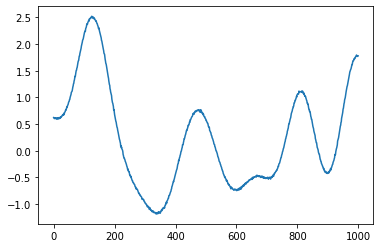

In [100]:
# Pick some reference example

I = 1
x0, u0, _ = dataset[I:I+1]
x0 = x0['x'].cuda()
u0 = u0.cuda()

plt.plot(x0.cpu().T)
#print("beta = ", u0[-1][-1].item())

In [108]:
# Extract bounds from the tail

tail = list(post._ratios.items())[0][1].tail
b = tail.forward(x0, u0, return_bounds = 0.1)
z_trunc = b[:, :N].cpu().detach().numpy().T

In [109]:
#z_trunc[:-33,:] *= 0.001
trunc = dict(z = z_trunc)
draws = get_trunc_draws(100, trunc)
len(draws)

100

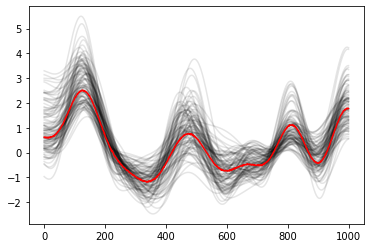

In [110]:
for i in range(100):
    x = model(draws[i]['z'])['x']
    plt.plot(x, "k", alpha = 0.1)
plt.plot(x0.cpu().T, "r")
#plt.gca().set_yscale('log')
#plt.ylim([0, 20])

### Round 2

In [23]:
s2 = np.zeros((NTRAIN, NPAR))
vu = Viewer(view, s2)
for i in range(len(draws)):
    vu.z[i] = draws[i]['z']

In [24]:
# Set dataset

observations2 = {"x": np.array([noise(model(s2[i]), s2[i])['x'] for i in range(len(s2))])}
dataset2 = SimpleDataset(observations2, s2, s2)
len(dataset2)

10000

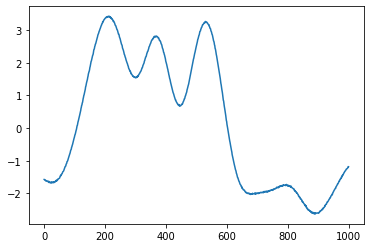

In [25]:
plt.plot(dataset2[2][0]['x'])

In [26]:
# Generate posterior estimator

post2 = swyft.Posteriors(dataset2)
partition = range(NPAR)
post2.add(partition, device='cuda', head_args = dict(online_norm = False), tail = RatioSampler)

In [27]:
# train!

post2.train(partition, max_epochs = 20, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 64, optimizer_args = dict(lr = 0.01))

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training: lr=0.005, Epoch=20, VL=21.48, TL=21.82


In [28]:
# Extract bounds from the tail

tail2 = list(post2._ratios.items())[0][1].tail
b2 = tail2.forward(x0, u0, return_bounds = 0.1)
z_trunc2 = b2[:, :N].cpu().detach().numpy().T

In [29]:
#z_trunc[:-33,:] *= 0.001
trunc2 = dict(z = z_trunc2)
draws2 = get_trunc_draws(100, trunc2)

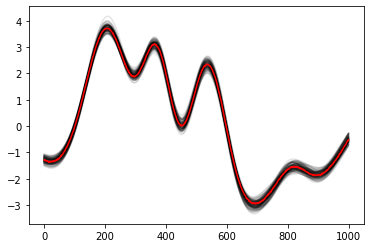

In [30]:
for i in range(100):
    x = model(draws2[i]['z'])['x']
    plt.plot(x, "k", alpha = 0.1)
plt.plot(x0.cpu().T, "r")
#plt.gca().set_yscale('log')
#plt.ylim([0, 20])